Basically, this notebook is testing everything within one step which means only one ancilla is used. We compared the results from Trotter_QRTE and exact matrix exponential for noiseless and noisy cases. After everything is settled here for one step process, we proceed to *post-selection with trotter* notebook for multiple step process.

In [3]:
import numpy as np
import scipy
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, state_fidelity, Operator
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit_aer import AerSimulator
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.primitives import Estimator
from qiskit.circuit.library import PauliEvolutionGate
import matplotlib.pyplot as plt
from scipy.linalg import expm, cosm
import warnings
import sys
import functools
import scipy as sc
from qiskit.visualization import plot_histogram

In [5]:
initial_state = Statevector.from_label('00000')
step = 10
time = 0.1
time_step = 2
nqubits = 4
order = 2
periodic = True
J = 1/np.sqrt(2)
def get_hamiltonian_y(nqubits, J, periodic):
    nqubits = nqubits - 1
    if periodic==False:
        ZZ_tuples = [('ZZY', [i, i+1, 0], J) for i in range(1, nqubits)]
        X_tuples = [("XY", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    else:
        ZZ_tuples = [('ZZY', [i, i+1, 0], J) for i in range(1, nqubits)]
        ZZ_tuples += [('ZZY', [nqubits, 1, 0], J)]
        X_tuples = [("XY", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    return hamiltonian.simplify()


def get_hamiltonian_i(nqubits, J, periodic):
    nqubits = nqubits - 1
    if periodic==False:
        ZZ_tuples = [('ZZI', [i, i+1, 0], J) for i in range(1, nqubits)]
        X_tuples = [("XI", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    else:
        ZZ_tuples = [('ZZI', [i, i+1, 0], J) for i in range(1, nqubits)]
        ZZ_tuples += [('ZZI', [nqubits, 1, 0], J)]
        X_tuples = [("XI", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    return hamiltonian.simplify()

def get_hamiltonian(nqubits, J):
    ZZ_tuples = [('ZZ', [i, i+1], J) for i in range(nqubits-1)]
    ZZ_tuples += [('ZZ', [nqubits-1, 0], J)]
    X_tuples = [("X", [i], J) for i in range(nqubits)]
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits)
    return hamiltonian.simplify()
circuit = QuantumCircuit(nqubits+1)
hamiltonian = get_hamiltonian_y(5, 1/np.sqrt(2), True)
U = expm(-1.0j * time * hamiltonian.to_matrix())
circuit.unitary(U, range(nqubits+1))
circuit = circuit.decompose(reps=2)
print(
    f"""
Gate counting with Exact 
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)




Gate counting with Exact 
--------------------------------------------

                  Depth: 950
             Gate count: 1279
    Nonlocal gate count: 443
         Gate breakdown: U: 836, CX: 443




In [3]:
hamiltonian = get_hamiltonian_y(5, 1/np.sqrt(2), True)

trotter_step_first_order = PauliEvolutionGate(hamiltonian, time)
circuit = QuantumCircuit(hamiltonian.num_qubits)
circuit.append(trotter_step_first_order, range(hamiltonian.num_qubits))
circuit = circuit.decompose(reps=2)
print(
    f"""
Trotter step with Suzuki Trotter (1st order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (1st order)
--------------------------------------------

                  Depth: 56
             Gate count: 72
    Nonlocal gate count: 24
         Gate breakdown: U1: 24, U2: 24, CX: 24




In [4]:
hamiltonian = get_hamiltonian_y(5, 1/np.sqrt(2), True)
second_order_formula = SuzukiTrotter(2)  # if not passed, order defaults to 2
trotter_step_second_order = PauliEvolutionGate(hamiltonian, time, synthesis=second_order_formula)
circuit = QuantumCircuit(hamiltonian.num_qubits)
circuit.append(trotter_step_second_order, range(hamiltonian.num_qubits))
circuit = circuit.decompose(reps=2)
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 105
             Gate count: 135
    Nonlocal gate count: 46
         Gate breakdown: CX: 46, U1: 45, U2: 44




In [17]:
hamiltonian = get_hamiltonian_y(5, 1/np.sqrt(2), True)
four_order_formula = SuzukiTrotter(4)  # if not passed, order defaults to 2
trotter_step_four_order = PauliEvolutionGate(hamiltonian, time, synthesis=four_order_formula)
circuit = QuantumCircuit(hamiltonian.num_qubits)
circuit.append(trotter_step_four_order, range(hamiltonian.num_qubits))
circuit = circuit.decompose(reps=2)
print(
    f"""
Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: 525
             Gate count: 675
    Nonlocal gate count: 230
         Gate breakdown: CX: 230, U1: 225, U2: 220




In [121]:
def count_gate(time, time_step):
    step = 10
    nqubits = 4
    order = 2
    periodic = True
    J = 1/np.sqrt(2)
    result = []
    for i in [0, 1, 2, 4]:
        print(i)
        if i==0:
            circuit = QuantumCircuit(5)
            hamiltonian = get_hamiltonian_y(5, 1/np.sqrt(2), True)
            U = expm(-1.0j * time * hamiltonian.to_matrix())
            circuit.unitary(U, range(nqubits+1))
            circuit = circuit.decompose(reps=2)
            result.append(circuit.depth()) #depth, total gate, nonlocal gates
            result.append(len(circuit))
            result.append(circuit.num_nonlocal_gates())
        elif i==1:
            hamiltonian = get_hamiltonian_y(5, 1/np.sqrt(2), True)
            trotter_step_first_order = PauliEvolutionGate(hamiltonian, time/time_step)
            circuit = QuantumCircuit(hamiltonian.num_qubits)
            for _ in range(time_step):
                circuit.append(trotter_step_first_order, range(hamiltonian.num_qubits))
            circuit = circuit.decompose(reps=2)
            result.append(circuit.depth()) #depth, total gate, nonlocal gates
            result.append(len(circuit))
            result.append(circuit.num_nonlocal_gates())
        else:
            hamiltonian = get_hamiltonian_y(5, 1/np.sqrt(2), True)
            second_order_formula = SuzukiTrotter(i)  # if not passed, order defaults to 2
            trotter_step_second_order = PauliEvolutionGate(hamiltonian, time/time_step, synthesis=second_order_formula)
            circuit = QuantumCircuit(hamiltonian.num_qubits)
            for _ in range(time_step):
              circuit.append(trotter_step_second_order, range(hamiltonian.num_qubits))
            circuit = circuit.decompose(reps=2)
            result.append(circuit.depth()) #depth, total gate, nonlocal gates
            result.append(len(circuit))
            result.append(circuit.num_nonlocal_gates())
    return result

In [128]:
print(count_gate(0.1, 10))

0
1
2
4
[949, 1278, 444, 560, 720, 240, 1050, 1350, 460, 5250, 6750, 2300]


In [126]:
print(count_gate(1, 1))

0
1
2
4
[953, 1282, 444, 56, 72, 24, 105, 135, 46, 525, 675, 230]


In [127]:
print(count_gate(10, 1))

0
1
2
4
[944, 1273, 444, 56, 72, 24, 105, 135, 46, 525, 675, 230]


/tmp/ipykernel_1974243/3829236010.py:17: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(21, 1, 2)


/tmp/ipykernel_1974243/3829236010.py:28: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/3829236010.py:32: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


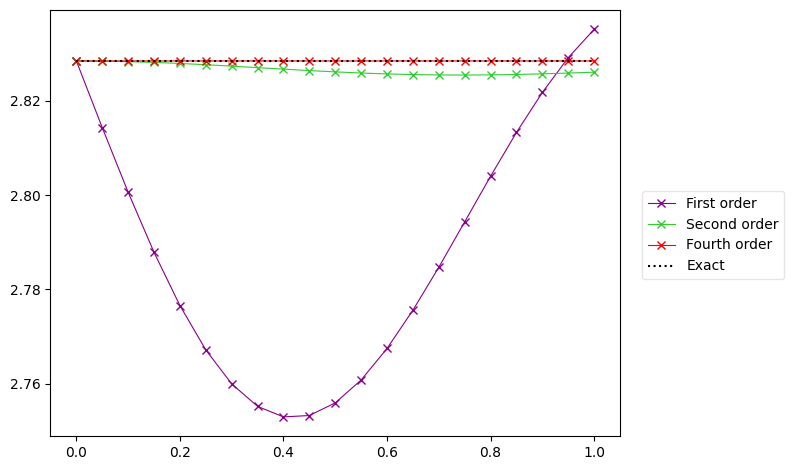

In [37]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian_i(5, 1/np.sqrt(2), True)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])


final_time = 1 #time
time_step = 20 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("00000")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

/tmp/ipykernel_1974243/3588119379.py:17: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(41, 1, 2)


/tmp/ipykernel_1974243/3588119379.py:28: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/3588119379.py:32: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


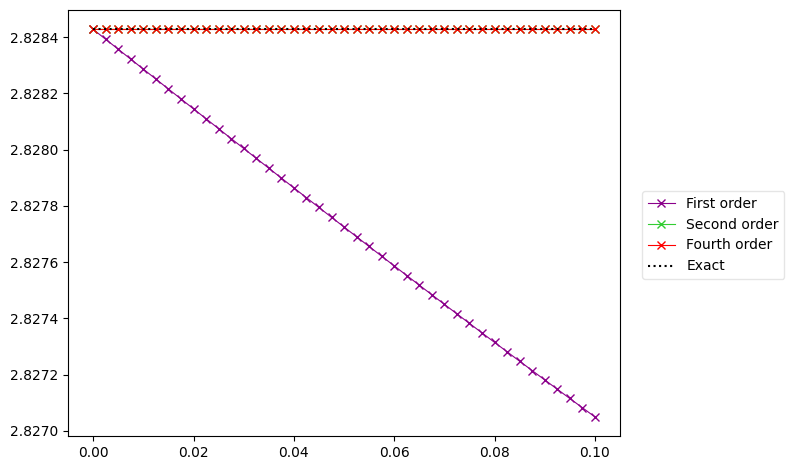

In [44]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian_i(5, 1/np.sqrt(2), True)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])


final_time = 0.1 #time
time_step = 40 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("00000")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

/tmp/ipykernel_1974243/268466236.py:17: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(21, 1, 2)


/tmp/ipykernel_1974243/268466236.py:28: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/268466236.py:32: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


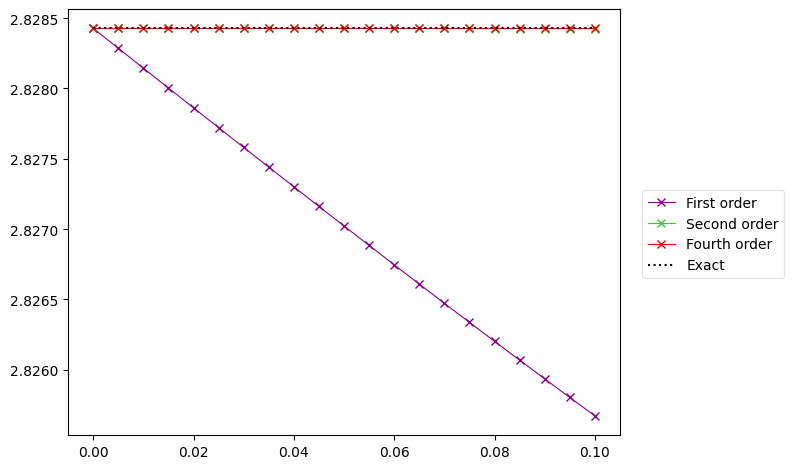

In [39]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian_i(5, 1/np.sqrt(2), True)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])


final_time = 0.1 #time
time_step = 20 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("00000")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

/tmp/ipykernel_1974243/1136843233.py:17: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(41, 1, 2)


/tmp/ipykernel_1974243/1136843233.py:28: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/1136843233.py:32: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


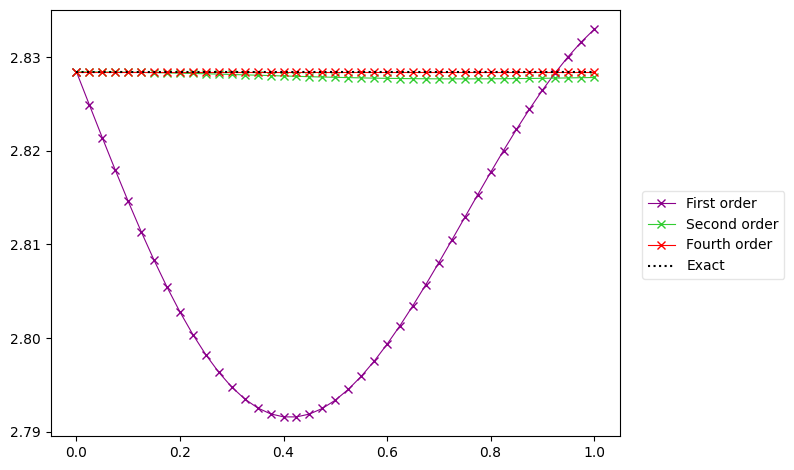

In [42]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian_i(5, 1/np.sqrt(2), True)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])


final_time = 1 #time
time_step = 40 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("00000")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

/tmp/ipykernel_1974243/3803391819.py:17: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(21, 1, 2)


/tmp/ipykernel_1974243/3803391819.py:28: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/3803391819.py:32: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


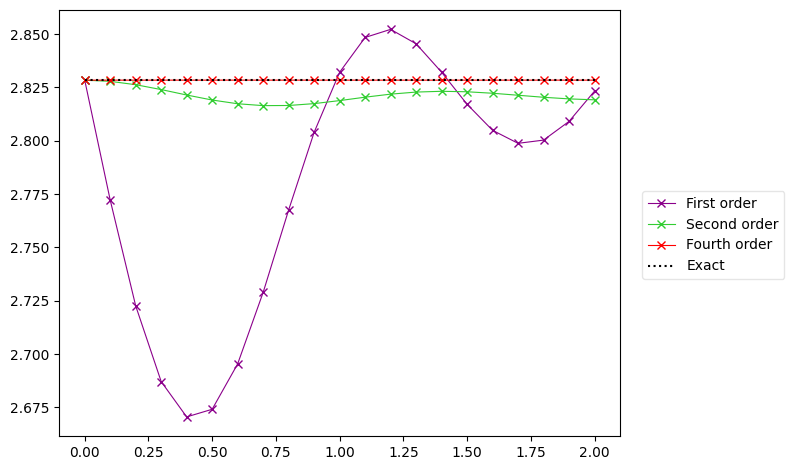

In [41]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian_i(5, 1/np.sqrt(2), True)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])


final_time = 2 #time
time_step = 20 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("00000")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

/tmp/ipykernel_1974243/2871949339.py:17: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(41, 1, 2)


/tmp/ipykernel_1974243/2871949339.py:28: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/2871949339.py:32: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


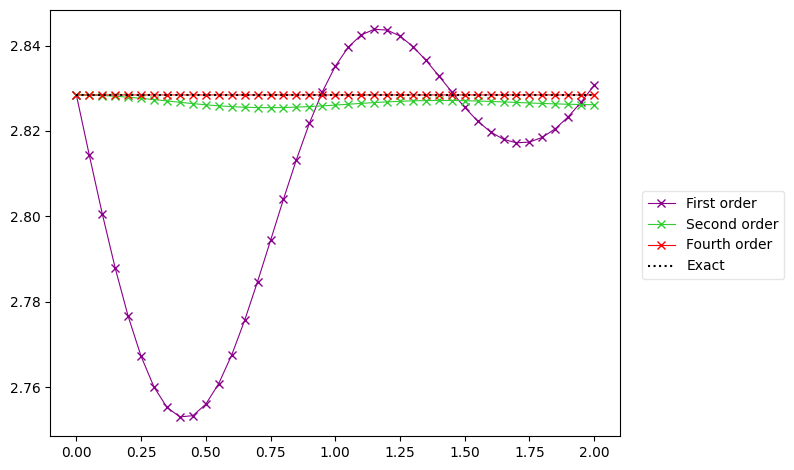

In [62]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian_i(5, 1/np.sqrt(2), True)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])


final_time = 2 #time
time_step = 40 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("00000")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

In [80]:
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
projector = np.array([[1, 0],
                     [0, 0]])
hamiltonian = Operator(np.kron(projector, hamiltonian.to_matrix()))
hamiltonian

Operator([[2.82842712+0.j, 0.70710678+0.j, 0.70710678+0.j, ..., 0.        +0.j, 0.        +0.j, 0.        +0.j],
          [0.70710678+0.j, 0.        +0.j, 0.        +0.j, ..., 0.        +0.j, 0.        +0.j, 0.        +0.j],
          [0.70710678+0.j, 0.        +0.j, 0.        +0.j, ..., 0.        +0.j, 0.        +0.j, 0.        +0.j],
          ...,
          [0.        +0.j, 0.        +0.j, 0.        +0.j, ..., 0.        +0.j, 0.        +0.j, 0.        +0.j],
          [0.        +0.j, 0.        +0.j, 0.        +0.j, ..., 0.        +0.j, 0.        +0.j, 0.        +0.j],
          [0.        +0.j, 0.        +0.j, 0.        +0.j, ..., 0.        +0.j, 0.        +0.j, 0.        +0.j]],
         input_dims=(2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2))


In [76]:
temp_A = np.array([[1, 2],
                    [3, 4]])
temp_B = np.array([[1, 0],
                    [0, 0]])
np.kron(temp_B, temp_A)

array([[1, 2, 0, 0],
       [3, 4, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [107]:
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
#exact_evolution
exact_energy = np.real([sv.data[:16].conj().T.dot(hamiltonian.to_matrix()).dot(sv.data[:16]) for sv in exact_evolution])

In [102]:
for sv in exact_evolution:
    print(sv.data[:16])

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[ 9.82065780e-01+0.j  1.68486493e-01+0.j -3.58490357e-03+0.j  4.20962590e-02+0.j -3.58490357e-03+0.j  4.20962590e-02+0.j -1.79137450e-03+0.j -1.01530477e-04+0.j -3.58490357e-03+0.j  4.20962590e-02+0.j -1.79137450e-03+0.j  3.36761771e-20+0.j -1.79137450e-03+0.j -1.01530477e-04+0.j  2.15456279e-06+0.j -7.61204391e-05+0.j]
[ 9.29047714e-01+0.j  3.29723804e-01+0.j -1.41595846e-02+0.j  8.22302214e-02+0.j -1.41595846e-02+0.j  8.22302214e-02+0.j -7.06268570e-03+0.j -8.05247890e-04+0.j -1.41595846e-02+0.j  8.22302214e-02+0.j -7.06268570e-03+0.j -1.86241369e-19+0.j -7.06268570e-03+0.j -8.05247890e-04+0.j  3.42131669e-05+0.j -6.03065575e-04+0.j]
[ 8.43264066e-01+0.j  4.76787667e-01+0.j -3.11923471e-02+0.j  1.18531615e-01+0.j -3.11923471e-02+0.j  1.18531615e-01+0.j -1.55106580e-02+0.j -2.67873597e-03+0.j -3.11923471e-02+0.j  1.18531615e-01+0.j -1.55106580e-02+0.j  4.77726582e-19+0.j -

In [108]:
exact_energy

array([2.82842712, 2.97141233, 2.91001951, 2.65438473, 2.24671532, 1.75406626, 1.25684223, 0.83503926, 0.55463444, 0.45649969, 0.54976147, 0.81073582, 1.18757778, 1.60977478, 2.00076422, 2.2914174 , 2.43199916, 2.40050724, 2.20596091, 1.88612422, 1.50014857, 1.11752293, 0.80536584, 0.61636776, 0.57954824, 0.69546046, 0.93665292, 1.2532379 , 1.58249094, 1.86068398, 2.03496494, 2.07310666, 1.9693541 , 1.7453232 , 1.44581489, 1.13033698, 0.86190613, 0.69519192, 0.66617755, 0.78522892, 1.03483987, 1.37246946, 1.73796444, 2.06423198, 2.289244  , 2.36721867, 2.27697665, 2.02598043, 1.64933997, 1.20396652, 0.75891643, 0.38363603, 0.13617732, 0.05344342, 0.14514657, 0.39249146, 0.75175581, 1.1620787 , 1.55604023, 1.87114906, 2.06022766, 2.09891493, 1.98904605, 1.75741842, 1.45027381, 1.12457268, 0.83767641, 0.63729451, 0.55346051, 0.59389534, 0.74348007, 0.96780992, 1.22007431, 1.44993437, 1.61274746, 1.67747129, 1.63186212, 1.48410675, 1.26069378, 1.0010148 , 0.74976483, 0.54858312, 0.4284767

Before, what we did actually is $\langle \psi_1 | Hs\otimes I|\psi_1\rangle$. Hwoever, that is not equal to the true expectation $\langle \psi_1' | Hs|\psi_1'\rangle$ where $|\psi_1'\rangle$ is the post-selected statevector from $|\psi_1\rangle$. Now we try to prove whether the true one is equal to $\langle \psi_1 | Hs\otimes $$\begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}$$|\psi_1\rangle$

/tmp/ipykernel_1974243/1806776246.py:18: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(21, 1, 2)


/tmp/ipykernel_1974243/1806776246.py:29: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/1806776246.py:33: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


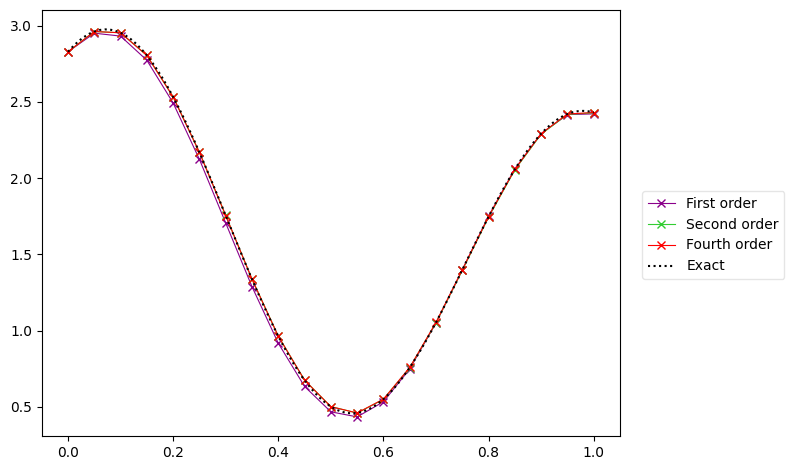

In [82]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
projector = np.array([[1, 0],
                     [0, 0]])
hamiltonian = Operator(np.kron(projector, hamiltonian.to_matrix()))
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
initial_state = Statevector.from_label("00000")
final_time = 1 #time
time_step = 20 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)


problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
expectation = np.array(result.observables)[:,:,0][:,0]
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])

###
trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

In [83]:
expectation2

array([2.82842712474619, 2.9614433119062267, 2.953197639544236, 2.8046256007944472, 2.5328301558974013, 2.169048551626124, 1.7549196339318867, 1.3375070831613285, 0.9636864507157115, 0.6745810875602996, 0.5007244860711767, 0.4585352491618164, 0.5485273434944247, 0.755462974268155, 1.0504152460214127, 1.3944726960243292, 1.7436170363979016, 2.0541638732108334, 2.2880911606212426, 2.417599435045292, 2.4283486227838256], dtype=object)

In [84]:
expectation

array([2.82842712474619, 2.9505735325759264, 2.9314486422636437, 2.7728079789071787, 2.492560796092246, 2.1226438560317744, 1.7052039895284348, 1.2875557899811327, 0.9165311035279515, 0.632910877946602, 0.4666182905341585, 0.4332564421590416, 0.5324063192763258, 0.7478821929030866, 1.0498994707439222, 1.3988744603040748, 1.750375845807211, 2.0606086615436245, 2.291750224427343, 2.4164811511143793, 2.4211598469917375], dtype=object)

/tmp/ipykernel_1974243/3052494745.py:18: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(41, 1, 2)


/tmp/ipykernel_1974243/3052494745.py:29: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/3052494745.py:33: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


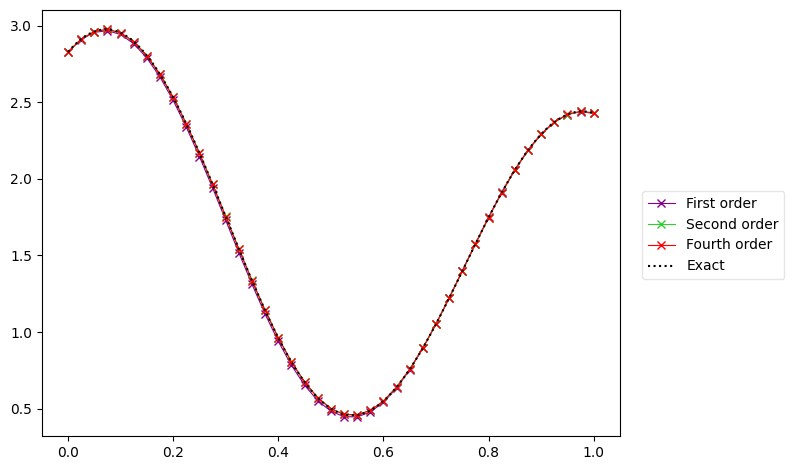

In [85]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
projector = np.array([[1, 0],
                     [0, 0]])
hamiltonian = Operator(np.kron(projector, hamiltonian.to_matrix()))
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
initial_state = Statevector.from_label("00000")
final_time = 1 #time
time_step = 40 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)


problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

/tmp/ipykernel_1974243/1170101106.py:18: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(21, 1, 2)


/tmp/ipykernel_1974243/1170101106.py:29: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/1170101106.py:33: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


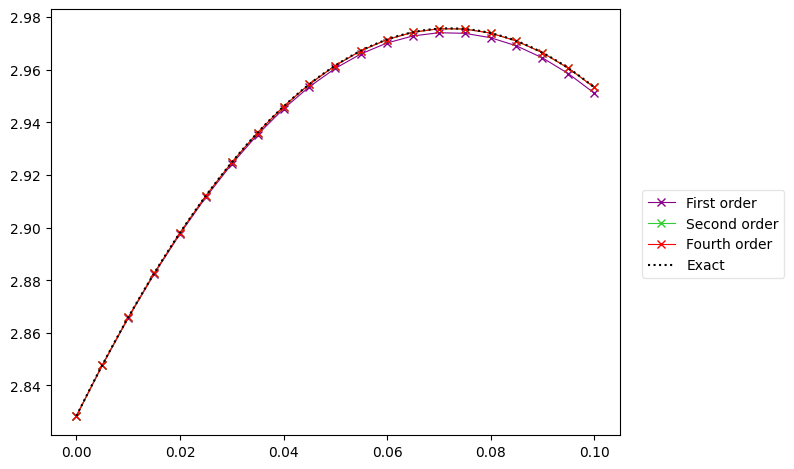

In [86]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
projector = np.array([[1, 0],
                     [0, 0]])
hamiltonian = Operator(np.kron(projector, hamiltonian.to_matrix()))
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
initial_state = Statevector.from_label("00000")
final_time = 0.1 #time
time_step = 20 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)


problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

/tmp/ipykernel_1974243/469442053.py:18: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(41, 1, 2)


/tmp/ipykernel_1974243/469442053.py:29: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/469442053.py:33: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


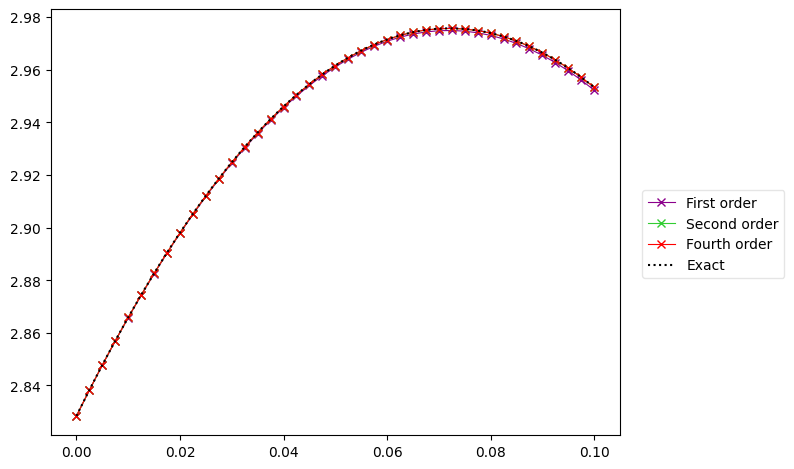

In [87]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
projector = np.array([[1, 0],
                     [0, 0]])
hamiltonian = Operator(np.kron(projector, hamiltonian.to_matrix()))
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
initial_state = Statevector.from_label("00000")
final_time = 0.1 #time
time_step = 40 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)


problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

/tmp/ipykernel_1974243/2381279565.py:18: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(21, 1, 2)


/tmp/ipykernel_1974243/2381279565.py:29: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/2381279565.py:33: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


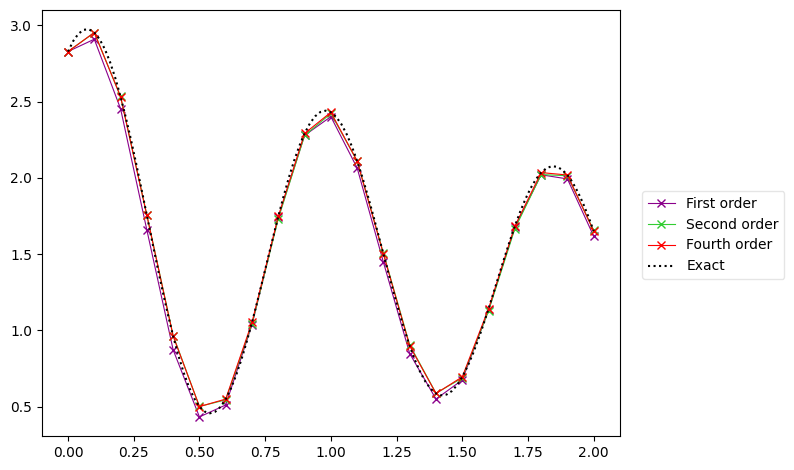

In [88]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
projector = np.array([[1, 0],
                     [0, 0]])
hamiltonian = Operator(np.kron(projector, hamiltonian.to_matrix()))
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
initial_state = Statevector.from_label("00000")
final_time = 2 #time
time_step = 20 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)


problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

/tmp/ipykernel_1974243/3915038280.py:18: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(41, 1, 2)


/tmp/ipykernel_1974243/3915038280.py:29: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/3915038280.py:33: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


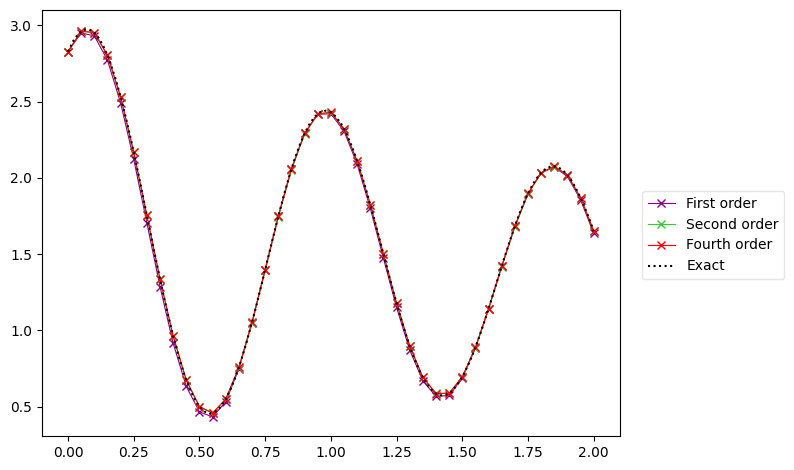

In [89]:
exact_times = np.linspace(0, time, 101)
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
projector = np.array([[1, 0],
                     [0, 0]])
hamiltonian = Operator(np.kron(projector, hamiltonian.to_matrix()))
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
initial_state = Statevector.from_label("00000")
final_time = 2 #time
time_step = 40 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)


problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

/tmp/ipykernel_1974243/2305543786.py:17: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())


(41, 1, 2)


/tmp/ipykernel_1974243/2305543786.py:28: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_1974243/2305543786.py:32: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


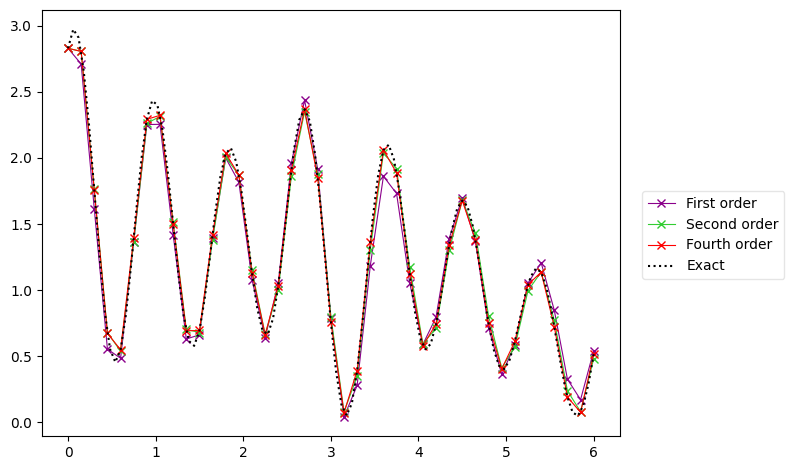

In [114]:
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
projector = np.array([[1, 0],
                     [0, 0]])
hamiltonian = Operator(np.kron(projector, hamiltonian.to_matrix()))
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
# We compute the exact evolution using the exp
H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
H_array = H.to_matrix()
initial_state = Statevector.from_label("00000")
final_time = 6 #time
time_step = 40 #time_step
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)


problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="x", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

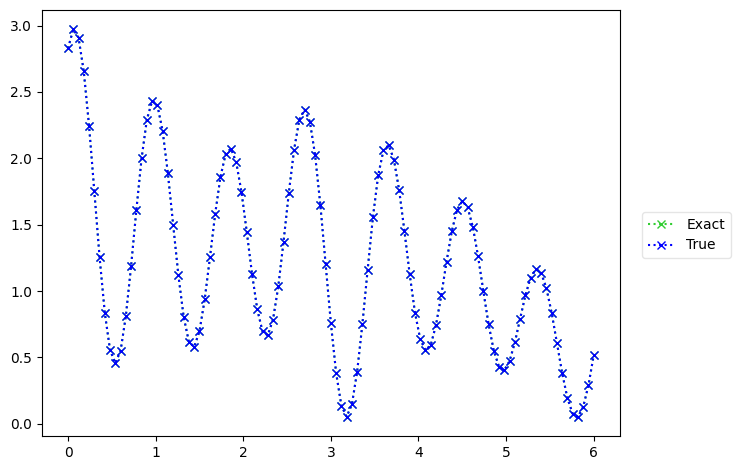

In [117]:
final_time = 6 #time
time_step = 40 #time_step
exact_times = np.linspace(0, final_time, 101)
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy_true = np.real([sv.data[:16].conj().T.dot(hamiltonian.to_matrix()).dot(sv.data[:16]) for sv in exact_evolution])
fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(exact_times, exact_energy, marker="x",c="limegreen", ls=":", label="Exact")
axes.plot(exact_times, exact_energy_true, marker="x", c="b", ls=":", label="True")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

## with scaled hamiltonian

/tmp/ipykernel_3203/2183932567.py:32: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_3203/2183932567.py:37: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())


(11, 1, 2)


/tmp/ipykernel_3203/2183932567.py:41: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


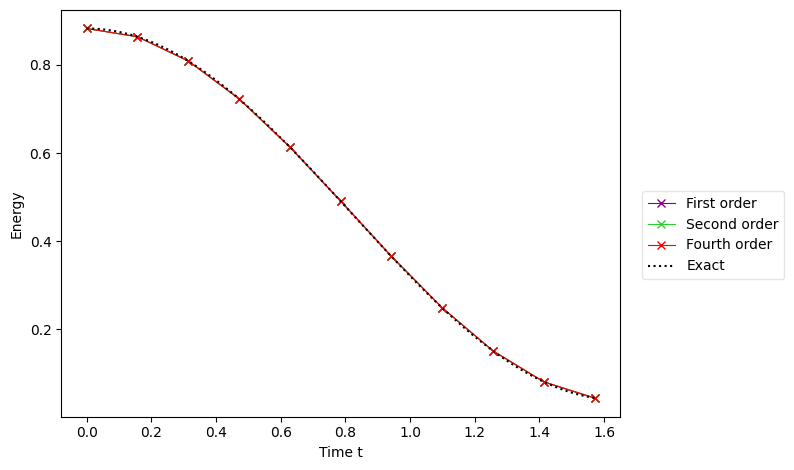

In [52]:
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**4)) / (emax - emin) ## scale H

#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(H_array, projector))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian = np.kron(H_array, projector2)
hamiltonian = Operator(hamiltonian)
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
initial_state = Statevector.from_label("00000")
final_time = np.pi/2 #time
time_step = 10 #time_step


# Exact parts
exact_times = np.linspace(0, final_time, 101)
# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * np.kron(H_array, projector))) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])

##Trotter parts
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="o", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="v", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
axes.set_xlabel('Time t')
axes.set_ylabel('Energy')
fig.tight_layout()

/tmp/ipykernel_3203/4117205775.py:33: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_3203/4117205775.py:38: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())


(11, 1, 2)


/tmp/ipykernel_3203/4117205775.py:42: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())


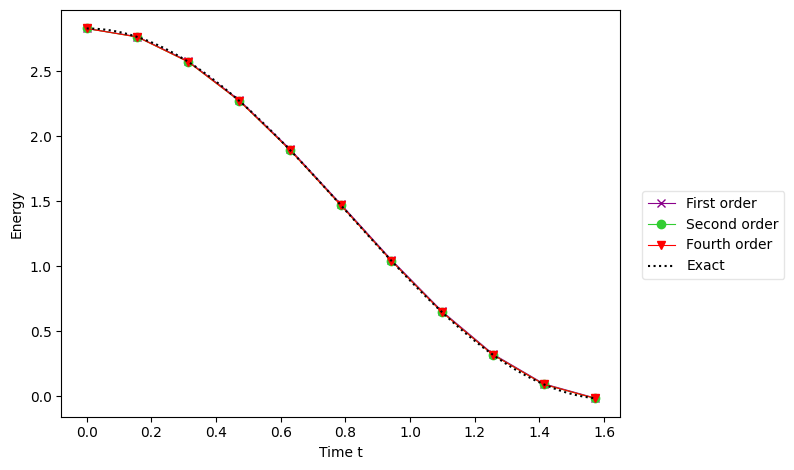

In [141]:
## calculate exp based on un-scaled hamiltonian
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**4)) / (emax - emin) ## scale H

#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(H_array, projector))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian = np.kron(get_hamiltonian(4, 1/np.sqrt(2)).to_matrix(), projector2)
hamiltonian = Operator(hamiltonian)
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
initial_state = Statevector.from_label("00000")
final_time = np.pi/2 #time
time_step = 10 #time_step


# Exact parts
exact_times = np.linspace(0, final_time, 101)
# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * np.kron(H_array, projector))) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian) for sv in exact_evolution])

##Trotter parts
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian])
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
print(np.array(result.observables).shape)
expectation = np.array(result.observables)[:,:,0][:,0]

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]

fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, expectation, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, expectation2, label="Second order", marker="o", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, expectation4, label="Fourth order", marker="v", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
axes.set_xlabel('Time t')
axes.set_ylabel('Energy')
fig.tight_layout()

### With QRTE-trotter class

/tmp/ipykernel_3203/1149329462.py:33: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_3203/1149329462.py:40: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
/tmp/ipykernel_3203/1149329462.py:46: Deprecat

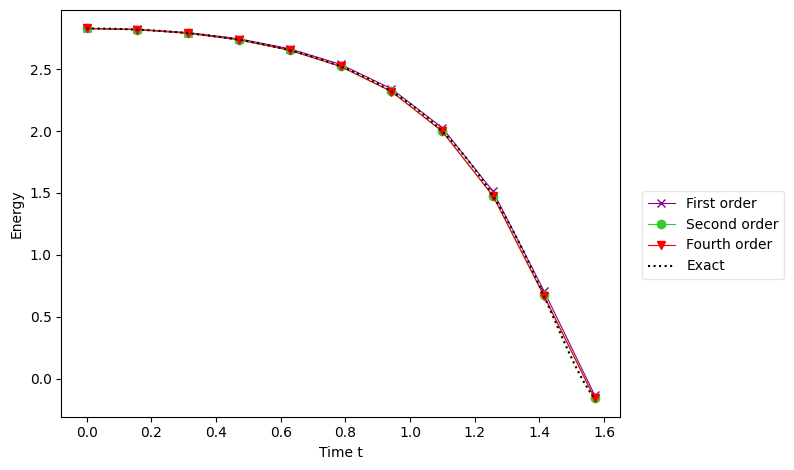

In [137]:
## calculate exp based on un-scaled hamiltonian
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**4)) / (emax - emin) ## scale H

#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian = np.kron(projector2, get_hamiltonian(4, 1/np.sqrt(2)).to_matrix())
hamiltonian = Operator(hamiltonian)
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
initial_state = Statevector.from_label("00000")
final_time = np.pi/2 #time
time_step = 10 #time_step
normalization_factor = SparsePauliOp.from_operator(Operator(np.kron(projector2, np.eye(2**nqubits))))

# Exact parts
exact_times = np.linspace(0, final_time, 101)
# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * np.kron(projector, H_array))) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian)/(sv.data.conj().dot(normalization_factor.to_matrix()).dot(sv.data)) for sv in exact_evolution])

##Trotter parts
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian, normalization_factor],)
trotter= TrotterQRTE(num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)
#print(np.array(result.observables).shape)
expectation = np.array(result.observables)[:,:,0][:,0]
normalization_factor1 = np.array(result.observables)[:,:,0][:,1]
normalized_exp = np.real([expectation[i]/(normalization_factor1[i]) for i in range(time_step+1)])

trotter2 = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result2 = trotter2.evolve(problem)
expectation2 = np.array(result2.observables)[:,:,0][:,0]
normalization_factor2 = np.array(result2.observables)[:,:,0][:,1]
normalized_exp2 = np.real([expectation2[i]/(normalization_factor2[i]) for i in range(time_step+1)])

trotter4 = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=time_step, estimator=Estimator())
result4 = trotter4.evolve(problem)
expectation4 = np.array(result4.observables)[:,:,0][:,0]
normalization_factor4 = np.array(result4.observables)[:,:,0][:,1]
normalized_exp4 = np.real([expectation4[i]/(normalization_factor4[i]) for i in range(time_step+1)])
fig, axes = plt.subplots()
times = np.linspace(0, final_time, time_step + 1)  # includes initial state
axes.plot(
    times, normalized_exp, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    times, normalized_exp2, label="Second order", marker="o", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    times, normalized_exp4, label="Fourth order", marker="v", c="r", ls="-", lw=0.8
)
axes.plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
axes.set_xlabel('Time t')
axes.set_ylabel('Energy')
fig.tight_layout()

In [138]:
normalized_exp[-1]

-0.13118755560863285

In [139]:
normalized_exp2[-1]

-0.1571036169798528

In [140]:
normalized_exp4[-1]

-0.15726076768335742

In [92]:
exact_energy[-1]

-0.15726074754010813

### with QC

In [6]:
nqubits = 4
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 10 #time_step
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = np.kron(projector2, get_hamiltonian(4, 1/np.sqrt(2)).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)
hamiltonian2 = np.kron(projector2, np.eye(2**nqubits))
## 1st order
formular = LieTrotter(reps=10)
trotter_step_first_order = PauliEvolutionGate(H, time, synthesis=formular)
circuit = QuantumCircuit(nqubits+1)
circuit.append(trotter_step_first_order, range(nqubits+1))
circuit = circuit.decompose(reps=2)
circuit.save_statevector()
# result = []
# result.append(circuit.depth()) #depth, total gate, nonlocal gates
# result.append(len(circuit))
# result.append(circuit.num_nonlocal_gates())
# result
simulator = AerSimulator()
result = simulator.run(circuit).result().data(0)['statevector']
statevector = result.data#[:2**nqubits]
expectation = (statevector.conj().T.dot(hamiltonian1.to_matrix())).dot(statevector)/(statevector.conj().T.dot(hamiltonian2).dot(statevector))
print(expectation)

(-0.13118755560862788+1.2221233405827873e-31j)


In [133]:
#exact
U = expm(-1.0j * time * np.kron(projector, H_array))
circuit1 = QuantumCircuit(nqubits+1)
circuit1.unitary(U, range(nqubits+1))
circuit=circuit1.decompose(reps=2)
result_count = []
result_count.append(circuit.depth()) #depth, total gate, nonlocal gates
result_count.append(len(circuit))
result_count.append(circuit.num_nonlocal_gates())
circuit1.save_statevector()

result = simulator.run(circuit1).result().data(0)['statevector']
statevector = result.data#[:2**nqubits]
expectation = (statevector.conj().dot(hamiltonian1.to_matrix())).dot(statevector)/(statevector.conj().T.dot(hamiltonian2).dot(statevector))
print(expectation)
print(result_count)

(-0.15726074754010871+0j)
[995, 1326, 444]


## With noise

QRTE class does not support aer_simulator with noise so we have to conver it to QC and run it with aer_simulator.

In [ ]:
def construct_trotter(nqubits, time, order): #second order trotterization
    J = 1/np.sqrt(2)
    hamiltonian1 = get_hamiltonian_y(nqubits+1, J, periodic=True)
    if order==1:
        formular = LieTrotter()
    else:
        formular = SuzukiTrotter()  # if not passed, order defaults to 2
    trotter_step_second_order = PauliEvolutionGate(hamiltonian1, time, synthesis=formular)
    circuit = QuantumCircuit(hamiltonian1.num_qubits)
    circuit.append(trotter_step_second_order, range(hamiltonian1.num_qubits))
    circuit = circuit.decompose(reps=2)
    return circuit

Firstly, we check that the results from previous QRTEclass and anticipated QC method are consistent.

In [107]:
nqubits = 4
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**4)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(H_array, projector))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian = np.kron(get_hamiltonian(4, 1/np.sqrt(2)).to_matrix(), projector2)
#hamiltonian = Operator(hamiltonian)
#hamiltonian = SparsePauliOp.from_operator(hamiltonian)

## 1st order
formular = LieTrotter()
trotter_step_first_order = PauliEvolutionGate(H, time, synthesis=formular)
circuit = QuantumCircuit(nqubits+1)
circuit.append(trotter_step_first_order, range(nqubits+1))
circuit = circuit.decompose(reps=2)
circuit.save_statevector()
#result = []
#result.append(circuit.depth()) #depth, total gate, nonlocal gates
#result.append(len(circuit))
#result.append(circuit.num_nonlocal_gates())
simulator = AerSimulator()
result = simulator.run(circuit).result().data(0)['statevector']
statevector = result.data[:2**nqubits]
expectation = (statevector.conj().dot(get_hamiltonian(4, 1/np.sqrt(2)))).dot(statevector)
print(expectation)
 


(0.5817146047777383+7.888609052210118e-31j)


In [104]:
result

[57, 74, 24]

In [186]:
nqubits = 4
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 10 #time_step
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(H_array, projector))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = np.kron(projector2, get_hamiltonian(4, 1/np.sqrt(2)).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)

## 1st order
formular = LieTrotter(reps=2)
trotter_step_first_order = PauliEvolutionGate(H, time, synthesis=formular)
circuit = QuantumCircuit(nqubits+1)
circuit.append(trotter_step_first_order, range(nqubits+1))
circuit = circuit.decompose(reps=2)
circuit.save_statevector()

error_rate = 1e-3
noise_model = NoiseModel()
error = depolarizing_error(error_rate, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
error1 = depolarizing_error(error_rate*10, 2)
noise_model.add_all_qubit_quantum_error(error1,'cx')
sim_d = AerSimulator(noise_model=noise_model)

circ_noise = transpile(circuit, sim_d)
result = []
result.append(circ_noise.depth()) #depth, total gate, nonlocal gates
result.append(len(circ_noise))
result.append(circ_noise.num_nonlocal_gates())
print(result)
#simulator = AerSimulator()
#result = simulator.run(circuit).result().data(0)['statevector']
#statevector = result.data#[:2**nqubits]
#expectation = (statevector.conj().T.dot(hamiltonian1.to_matrix())).dot(statevector)
#print(expectation)
noise_result = sim_d.run(circ_noise, shots=1024).result()
#result = sim_d.run(circuit).result()
u=noise_result.data(0)['statevector'].data#[:2**nqubits]
#u = u/np.linalg.norm(u)
statevector = u
expectation = (statevector.conj().dot(hamiltonian1.to_matrix())).dot(statevector)/(statevector.conj().T.dot(hamiltonian2).dot(statevector))
#initial_state = Statevector.from_label("00000")
#final_time = np.pi/2 #time
#time_step = 10 #time_step
print(expectation)

[67, 84, 48]
(0.5152469437779832-4.032691579534237e-31j)


In [205]:
nqubits = 4
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 10 #time_step
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(H_array, projector))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = np.kron(projector2, get_hamiltonian(4, 1/np.sqrt(2)).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)

U = expm(-1.0j * time * np.kron(projector, H_array))
circuit1 = QuantumCircuit(nqubits+1)
circuit1.unitary(U, range(nqubits+1))
circuit = circuit1.decompose(reps=2)
circuit.save_statevector()

error_rate = 1e-4
noise_model = NoiseModel()
error = depolarizing_error(error_rate, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
error1 = depolarizing_error(error_rate*10, 2)
noise_model.add_all_qubit_quantum_error(error1,'cx')
sim_d = AerSimulator(noise_model=noise_model)

circ_noise = transpile(circuit, sim_d)
result = []
result.append(circ_noise.depth()) #depth, total gate, nonlocal gates
result.append(len(circ_noise))
result.append(circ_noise.num_nonlocal_gates())
print(result)
#simulator = AerSimulator()
#result = simulator.run(circuit).result().data(0)['statevector']
#statevector = result.data#[:2**nqubits]
#expectation = (statevector.conj().T.dot(hamiltonian1.to_matrix())).dot(statevector)
#print(expectation)
noise_result = sim_d.run(circ_noise, shots=1024).result()
#result = sim_d.run(circuit).result()
u=noise_result.data(0)['statevector'].data#[:2**nqubits]
#u = u/np.linalg.norm(u)
statevector = u
expectation = (statevector.conj().dot(hamiltonian1.to_matrix())).dot(statevector)/(statevector.conj().T.dot(hamiltonian2).dot(statevector))
#initial_state = Statevector.from_label("00000")
#final_time = np.pi/2 #time
#time_step = 10 #time_step
print(expectation)

[855, 1128, 444]
(-1.28374406134314-3.9662028889994546e-17j)


In [200]:
nqubits = 4
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 10 #time_step
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(H_array, projector))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = np.kron(projector2, get_hamiltonian(4, 1/np.sqrt(2)).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)

U = expm(-1.0j * time * np.kron(projector, H_array))
circuit1 = QuantumCircuit(nqubits+1,1)
circuit1.unitary(U, range(nqubits+1))
circuit = circuit1.decompose(reps=2)
circuit.save_statevector()

error_rate = 1e-4
noise_model = NoiseModel()
error = depolarizing_error(error_rate, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
error1 = depolarizing_error(error_rate*10, 2)
noise_model.add_all_qubit_quantum_error(error1,'cx')
sim_d = AerSimulator(noise_model=noise_model)

circ_noise = transpile(circuit, sim_d)
result = []
result.append(circ_noise.depth()) #depth, total gate, nonlocal gates
result.append(len(circ_noise))
result.append(circ_noise.num_nonlocal_gates())
print(result)
#simulator = AerSimulator()
#result = simulator.run(circuit).result().data(0)['statevector']
#statevector = result.data#[:2**nqubits]
#expectation = (statevector.conj().T.dot(hamiltonian1.to_matrix())).dot(statevector)
#print(expectation)
noise_result = sim_d.run(circ_noise, shots=1024).result()
#result = sim_d.run(circuit).result()
u=noise_result.data(0)['statevector'].data#[:2**nqubits]
#u = u/np.linalg.norm(u)
statevector = u
expectation = (statevector.conj().dot(hamiltonian1.to_matrix())).dot(statevector)/(statevector.conj().T.dot(hamiltonian2).dot(statevector))
#initial_state = Statevector.from_label("00000")
#final_time = np.pi/2 #time
#time_step = 10 #time_step
print(expectation)
#plot_histogram(noise_result.get_counts())

[855, 1128, 444]
(-0.33294881075150173-3.1071880958433157e-17j)
